In [1]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sncosmo

In [2]:
import os
from copy import deepcopy

In [3]:
import gedankenLSST
import numpy as np
import pandas as pd

In [4]:
from LSSTmetrics import PerSNMetric

In [5]:
from lsst.sims.photUtils import BandpassDict

## Some setup 

In [6]:
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [7]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


### Example of Daily Cadence

Here we set up an example where the SN are measured at a daily cadence

In [8]:
dailyCadence = deepcopy(gedankenLSST.LSSTReq)

In [9]:
# This is a dictionary with the following keys
dailyCadence.keys()

['Duration', 'bF', 'meanNumVisits', 'medianSVD']

In [12]:
dailyCadence['Duration'] # Says the survey is 10 years

3650.0

In [13]:
dailyCadence['meanNumVisits'] # Gives the number of visits during the duration, (mean is over LSST fields)

u     56
g     80
r    184
i    184
z    160
y    160
dtype: float64

In [14]:
dailyCadence['bF'] # bumpFactors increase the cadence in filters by these factors

u    1
g    1
r    1
i    1
z    1
y    1
dtype: float64

In [15]:
dailyCadence['medianSVD'] # median single visit 5 sigma depth in LSST

u    23.9
g    25.0
r    24.7
i    24.0
z    23.3
y    22.1
dtype: float64

In [16]:
# Now, we will make the cadence a 'daily cadence' in each band
dailyCadence['meanNumVisits'] = pd.Series(np.repeat(3650.,6), index=['u','g','r','i','z','y'], copy=True)

In [17]:
dailyCadence['meanNumVisits']

u    3650
g    3650
r    3650
i    3650
z    3650
y    3650
dtype: float64

In [20]:
#Now create a set of observations at a particular ra, dec within a a time window
observations = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=dailyCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-30., 50.])

In [21]:
# This is a pandas.DataFrame which should look like columns of OpSim
observations.summary.head()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night
0,49540.000000,g,58,-27,25,1,49540
1,49540.987654,g,58,-27,25,1,49540
2,49541.975309,g,58,-27,25,1,49541
3,49542.962963,g,58,-27,25,1,49542
4,49543.950617,g,58,-27,25,1,49543


In [22]:
snDaily = PerSNMetric(summarydf=observations.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

In [23]:
# Now we can look at a light curve (no scatter)
snDaily.lightcurve.head()

480


,time,band,flux,fluxerr,zp,zpsys,SNR,fiveSigmaDepth,night,DetectionEfficiency
191,49568.641975,r,7.881685e-10,2.817158e-11,0,ab,27.977437,24.7,49568,NaN
190,49567.654321,r,7.860323e-10,2.816589e-11,0,ab,27.907246,24.7,49567,NaN
192,49569.629630,r,7.841457e-10,2.816086e-11,0,ab,27.845236,24.7,49569,NaN
189,49566.666667,r,7.780139e-10,2.814451e-11,0,ab,27.643537,24.7,49566,NaN
193,49570.617284,r,7.755101e-10,2.813783e-11,0,ab,27.561116,24.7,49570,NaN


In [24]:
# We can coadd the light curve in nights if necessary
snDaily.coaddedLightCurve.head()

480


zpsys          flux  zp       fluxerr          time       SNR
night band                                                              
49540 g       ab  6.940171e-16   0  1.970072e-11  49540.987654  0.000035
      i       ab  3.315292e-13   0  4.973095e-11  49540.987654  0.006666
      r       ab  1.327880e-13   0  2.598756e-11  49540.987654  0.005110
      u       ab  1.224706e-16   0  5.421613e-11  49540.987654  0.000002
      y       ab  6.743877e-13   0  2.876881e-10  49540.987654  0.002344

/Users/rbiswas/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['modelFlux'] = lc['flux']
/Users/rbiswas/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['deviation'] = np.random.normal(size=len(lc['flux']))
/Users/rbiswas/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

480


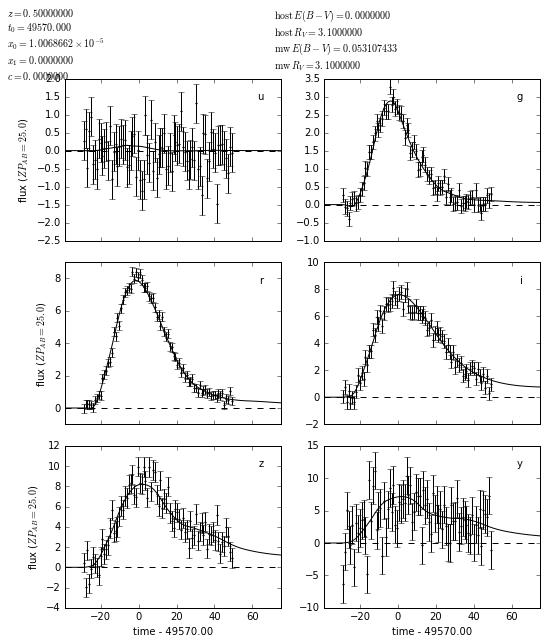

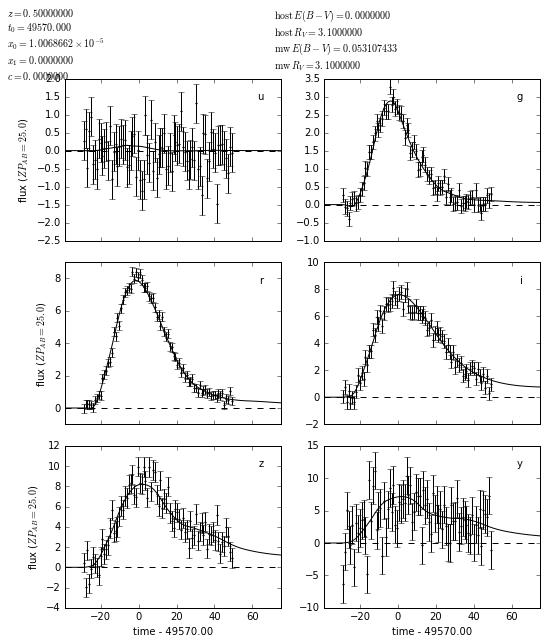

In [25]:
# We can get plots with scatter, and a seed. This can also have a nightly coadd 
snDaily.lcplot(scattered=True, seed=0)

In [26]:
# the same light curves in a format where we can easily fit
snDaily.SNCosmoLC()

480


index,time,band,flux,fluxerr,zp,zpsys,SNR,fiveSigmaDepth,night,DetectionEfficiency,modelFlux,deviation
int64,float64,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64
191,49568.6419753,r,7.88168540802e-10,2.81715775841e-11,0.0,ab,27.9774371332,24.7,49568.0,nan,7.88168540802e-10,1.76405234597
190,49567.654321,r,7.86032317019e-10,2.81658860171e-11,0.0,ab,27.9072462532,24.7,49567.0,nan,7.86032317019e-10,0.400157208367
192,49569.6296296,r,7.84145741367e-10,2.8160858634e-11,0.0,ab,27.8452355291,24.7,49569.0,nan,7.84145741367e-10,0.978737984106
189,49566.6666667,r,7.78013875392e-10,2.8144512117e-11,0.0,ab,27.643537474,24.7,49566.0,nan,7.78013875392e-10,2.2408931992
193,49570.617284,r,7.75510115502e-10,2.81378347863e-11,0.0,ab,27.5611155368,24.7,49570.0,nan,7.75510115502e-10,1.86755799015
188,49565.6790123,r,7.64527092438e-10,2.81085251874e-11,0.0,ab,27.1991179665,24.7,49565.0,nan,7.64527092438e-10,-0.977277879876
194,49571.6049383,r,7.63214948326e-10,2.81050215194e-11,0.0,ab,27.1558215246,24.7,49571.0,nan,7.63214948326e-10,0.950088417526
195,49572.5925926,r,7.48176838892e-10,2.80648357468e-11,0.0,ab,26.6588711098,24.7,49572.0,nan,7.48176838892e-10,-0.151357208298
187,49564.691358,r,7.4607818804e-10,2.80592230249e-11,0.0,ab,26.589410098,24.7,49564.0,nan,7.4607818804e-10,-0.103218851794


#### An LSST Cadence

In [28]:
lsstCadence = deepcopy(gedankenLSST.LSSTReq)

In [29]:
lsst_obs = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=lsstCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-30., 50.])

In [30]:
lsstCadence

{'Duration': 3650.0, 'bF': u    1
 g    1
 r    1
 i    1
 z    1
 y    1
 dtype: float64, 'meanNumVisits': u     56
 g     80
 r    184
 i    184
 z    160
 y    160
 dtype: float64, 'medianSVD': u    23.9
 g    25.0
 r    24.7
 i    24.0
 z    23.3
 y    22.1
 dtype: float64}

In [31]:
snLSST = PerSNMetric(summarydf=lsst_obs.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

19


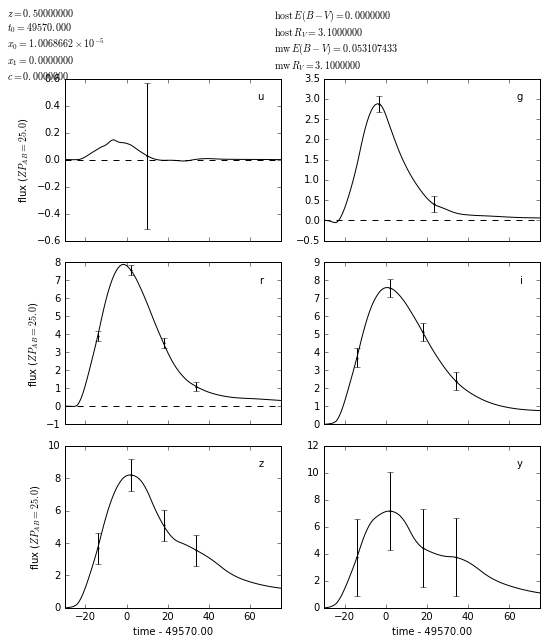

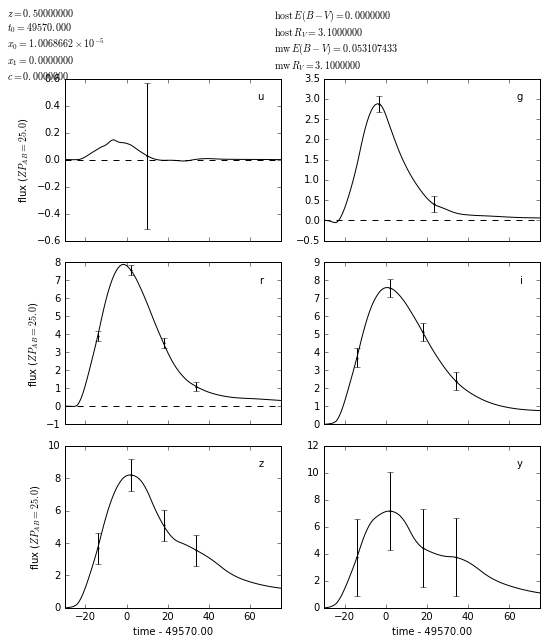

In [32]:
snLSST.lcplot()

In [33]:
snLSST.SNCosmoLC()

19


index,time,band,flux,fluxerr,zp,zpsys,SNR,fiveSigmaDepth,night,DetectionEfficiency,modelFlux,deviation
int64,float64,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64
10,49572.0,r,7.57526079086e-10,2.80898261293e-11,0.0,ab,26.9679874699,24.7,49572.0,nan,7.57526079086e-10,1.76405234597
5,49572.0,i,7.56940442233e-10,5.12442084128e-11,0.0,ab,14.7712388517,24.0,49572.0,nan,7.56940442233e-10,0.400157208367
9,49556.0,r,3.89801970773e-10,2.70895316695e-11,0.0,ab,14.389394971,24.7,49556.0,nan,3.89801970773e-10,0.978737984106
1,49566.6666667,g,2.87564179453e-10,2.05495952042e-11,0.0,ab,13.9936663762,25.0,49566.0,nan,2.87564179453e-10,2.2408931992
11,49588.0,r,3.49703900391e-10,2.69782130991e-11,0.0,ab,12.962456005,24.7,49588.0,nan,3.49703900391e-10,1.86755799015
6,49588.0,i,5.11458395986e-10,5.07581753866e-11,0.0,ab,10.0763747335,24.0,49588.0,nan,5.11458395986e-10,-0.977277879876
22,49572.0,z,8.20166416309e-10,9.62467916063e-11,0.0,ab,8.52149357522,23.3,49572.0,nan,8.20166416309e-10,0.950088417526
4,49556.0,i,3.7046271689e-10,5.047690037e-11,0.0,ab,7.33925249321,24.0,49556.0,nan,3.7046271689e-10,-0.151357208298
23,49588.0,z,5.08786105116e-10,9.57721142029e-11,0.0,ab,5.31246604871,23.3,49588.0,nan,5.08786105116e-10,-0.103218851794


####  Using BumpFactor

In [34]:
thriceLsstCadence = deepcopy(gedankenLSST.LSSTReq)

In [35]:
thriceLsstCadence['bF'] = 3

In [36]:
snLSST = PerSNMetric(summarydf=lsst_obs.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

3

19


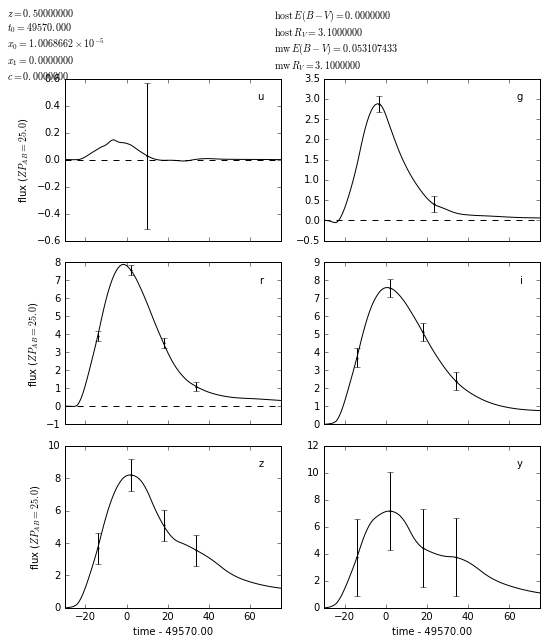

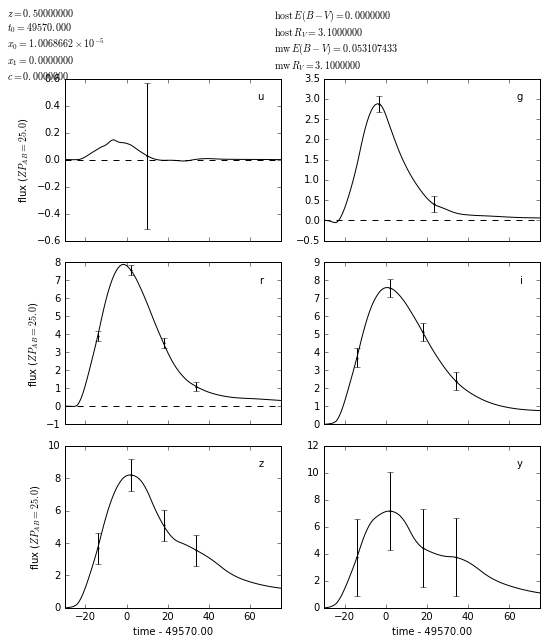

In [37]:
snLSST.lcplot()

# Scratch

In [14]:
df = sn.summary

In [15]:
df['filter'].unique()

array(['g', 'i', 'r', 'u', 'y', 'z'], dtype=object)

In [16]:
df.columns

Index([u'expMJD', u'filter', u'ra', u'dec', u'fiveSigmaDepth', u'fieldID',
       u'night'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bc37050>]], dtype=object)

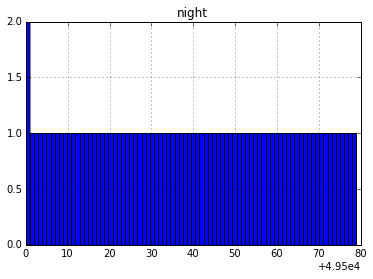

In [17]:
df[df['filter'] == 'u'].hist('night',bins=80)

In [18]:
s = gedankenLSST.SNObs(summarydf=df, t0=49530, lsst_bp=lsst_bp)

In [19]:
np.degrees(0)

0.0

In [20]:
s.radeg

0.0

In [21]:
l = s.lightcurve

480


/Users/rbiswas/.local/lib/python2.7/site-packages/gedankenLSST/sninLSST.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SNR'] = df['flux'] / df['fluxerr']


In [22]:
type(l)

pandas.core.frame.DataFrame

In [23]:
l.query('SNR > 5.').night

15     49514
16     49515
17     49516
18     49517
19     49518
20     49519
21     49520
22     49521
23     49522
24     49523
25     49524
26     49525
27     49526
28     49527
29     49528
30     49529
31     49530
32     49531
33     49532
34     49533
35     49534
36     49535
37     49536
38     49537
39     49538
40     49539
41     49540
42     49541
43     49542
44     49543
       ...  
426    49520
427    49521
428    49522
429    49523
430    49524
431    49525
432    49526
433    49527
434    49528
435    49529
436    49530
437    49531
438    49532
439    49533
440    49534
441    49535
442    49536
443    49537
444    49538
445    49539
446    49540
447    49541
448    49542
449    49543
450    49544
451    49545
452    49546
453    49547
454    49548
455    49549
Name: night, dtype: float64

In [24]:
import sncosmo

In [25]:
dir(sn)

['Observations',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_observations',
 'add_depth',
 'bumpFactors',
 'cadence',
 'dec',
 'fieldID',
 'meanNumObsperBand',
 'mjd_center',
 'ra',
 'requirements',
 'summary',
 'timeWindow',
 'uniformlySpacedEvents']